In [1]:
import json
import os
import re

from bs4 import BeautifulSoup
import pandas as pd
import psycopg2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from patsy import dmatrices
import scipy.stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms

In [2]:
connection = psycopg2.connect(host="localhost", dbname="postgres", user="postgres", port=5432)

In [3]:
commit_pct = pd.read_sql("SELECT DISTINCT user_id, package_id, commit_pct FROM open_source.issue_contributors", connection)

In [4]:
language = pd.read_sql("SELECT id as package_id, language FROM open_source.packages", connection)

In [5]:
query = """
SELECT COUNT(*) as total_user_issues, package_id, user_id
FROM open_source.issue_contributors
GROUP BY package_id, user_id
"""

In [6]:
total_user_issues = pd.read_sql(query, connection)

In [7]:
query = """
SELECT COUNT(*) as total_user_comments, package, organization, user_id
FROM open_source.issue_comments
GROUP BY package, organization, user_id
"""

In [8]:
total_user_comments = pd.read_sql(query, connection)

In [9]:
query = """
    SELECT id as package_id, package_name as package, org_name as organization
    FROM open_source.packages
"""

In [10]:
packages = pd.read_sql(query, connection)
package_lookup = dict()
for i in packages.index:
    package_lookup[packages.loc[i]['package_id']] = (packages.loc[i]['package'], packages.loc[i]['organization'])

In [11]:
with open("/home/matt/data/tagtog_requirement_quality_600/requirement_quality/annotations-legend.json", "r") as f:
    annotations_legend = json.load(f)

In [12]:
HTML_DIR = "/home/matt/data/tagtog_requirement_quality_600/requirement_quality/plain.html/pool"
filenames = os.listdir(HTML_DIR)

filename_lookup = dict()
for filename in filenames:
    with open(os.path.join(HTML_DIR, filename)) as f:
        html = BeautifulSoup(f).find("html")
        if html:
            filename_lookup[html['id']] = html['data-origid']

In [13]:
ANNO_DIR = "/home/matt/data/tagtog_requirement_quality_600/requirement_quality/ann.json/master/pool"
filenames = os.listdir(ANNO_DIR)

data = {"issue_id": [], "user_id": [], "package_id":[], "package": [], "organization": []}
for value in annotations_legend.values():
    data[value] = []

for filename in filenames:
    try:
        orig_filename = filename_lookup[filename.replace(".ann.json", "")]
    except KeyError:
        continue
    
    with open(os.path.join(ANNO_DIR, filename), "r") as f:
        labels = json.load(f)
        
    for key, value in annotations_legend.items():
        data[value].append(labels['metas'].get(key, {"value": False})["value"])
    
    
    package_id, user_id, issue_id = tuple(orig_filename.split("-"))
    package, organization = package_lookup[package_id]

    data["package_id"].append(package_id)
    data["issue_id"].append(issue_id)
    data["user_id"].append(user_id)
    data["package"].append(package)
    data["organization"].append(organization)
    
data = pd.DataFrame(data)

In [14]:
github_data = pd.read_csv("../github_data.csv")
similarity_data = pd.read_csv("../similarity_data.csv")
reqs_data = pd.read_csv("~/data/requirement_quality.csv")

reqs_data["user_id"] = reqs_data["user_id"].astype(str)
reqs_data["issue_id"] = reqs_data["issue_id"].astype(str)

In [15]:
data = data.merge(github_data, how="inner", on=["package", "organization", "package_id"])
data = data.merge(reqs_data, how="inner", on=["package_id", "user_id", "issue_id", "package", "organization"])
data = data.merge(total_user_issues, how="inner", on=["package_id", "user_id"])
data = data.merge(total_user_comments, how="inner", on=["package", "organization", "user_id"])
data = data.merge(similarity_data, how="inner", on=["package_id"])
data = data.merge(commit_pct, how="inner", on=["package_id", "user_id"])
data = data.merge(language, how="inner", on=["package_id"])

In [16]:
data["req_quality"] = 0
for key in annotations_legend.values():
    data[key] = data[key].astype(int)
    data["req_quality"] += data[key]

In [17]:
data['issue_length'] = data["body"].apply(lambda x: len(x))

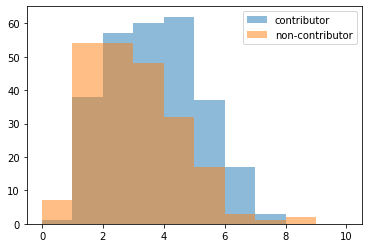

In [18]:
bins = np.linspace(0, 10, 11)

plt.hist(data[data['contributor'] == True]['req_quality'], bins, alpha=0.5, label='contributor')
plt.hist(data[data['contributor'] == False]['req_quality'], bins, alpha=0.5, label='non-contributor')
plt.legend(loc='upper right')
plt.show()

In [19]:
for package_id, count in dict(data['package_id'].value_counts()).items():
    if count > 10:
        data[f"package_{package_id}"] = (data['package_id'] == package_id).astype(int)
        print(f"package_{package_id} - {count}")

package_ab744db5ca5949d29d101293d7804811 - 32
package_6d8b278d51ff412096368f4a48280546 - 26
package_4d8c8752a3bb4c8a87d04ecf93603f67 - 26
package_170d4a8b6fc64dad8545d46c09cca126 - 24
package_4e4a7c109bdb4d4b8cd175f65e3a0790 - 19
package_6a36e03c0f1441b49faa8f6f78509b9b - 19
package_108f135ddec84117a774448e7e2b49d3 - 17
package_ae03aa731d6c4b93a003d63cd90e7bc2 - 16
package_4db515f7cdac4214a30c071d3c986761 - 15
package_3fccd9f1b3b0419fa028615e9cf39ed6 - 15
package_5f0b93551fd94e84b31a0ee1425b8a55 - 14
package_6af468b3b683484e918f236be48cf041 - 13
package_aca070379940455cbca1170e1660d740 - 12


In [20]:
data['package_id'].describe()

count                                  493
unique                                  72
top       ab744db5ca5949d29d101293d7804811
freq                                    32
Name: package_id, dtype: object

In [21]:
data['language'].value_counts()

javascript    177
python        107
cpp           103
java           68
php            38
Name: language, dtype: int64

In [22]:
data['commit_pct_2'] = data['commit_pct']**2
data['similarity_2'] = data['similarity']**2
data['issue_length_2'] = data['issue_length']**2
data['issue_length_3'] = data['issue_length']**3
data['code_blocks'] = data['body'].apply(lambda x: x.count("`"))
data['code_blocks_2'] = data['code_blocks']**2
data['links'] = data['body'].apply(lambda x: x.count("http"))
data['num_words'] = data['body'].apply(lambda x: len(x.split()))

In [48]:
down_sample = []
for name, group in data.groupby('package_id'):
    if len(group) <= 10:
        down_sample.append(group)
    else:
        down_sample.append(group.sample(10))
down_sample = pd.concat(down_sample)
down_sample.reset_index(inplace=True, drop=True)

In [49]:
down_sample['language'].value_counts()

javascript    107
cpp            87
python         81
java           64
php            36
Name: language, dtype: int64

In [54]:
down_sample['contributor'].value_counts()

True     208
False    167
Name: contributor, dtype: int64

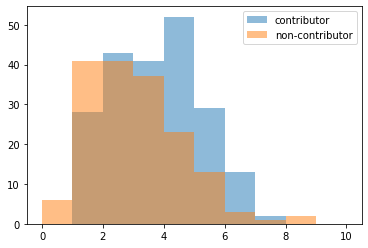

In [50]:
bins = np.linspace(0, 10, 11)

plt.hist(down_sample[down_sample['contributor'] == True]['req_quality'], bins, alpha=0.5, label='contributor')
plt.hist(down_sample[down_sample['contributor'] == False]['req_quality'], bins, alpha=0.5, label='non-contributor')
plt.legend(loc='upper right')
plt.show()

In [53]:
formula = """
req_quality ~ contributor +  similarity  + crowd_pct  + language + 
code_blocks + code_blocks_2 + issue_length + issue_length_2 + issue_length_3 +
total_issues + total_contributors 
"""
y, X = dmatrices(formula, data=down_sample, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
print(len(res.params))
print(res.summary())

15
                            OLS Regression Results                            
Dep. Variable:            req_quality   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     16.93
Date:                Sat, 08 Aug 2020   Prob (F-statistic):           6.19e-32
Time:                        22:32:49   Log-Likelihood:                -601.12
No. Observations:                 375   AIC:                             1232.
Df Residuals:                     360   BIC:                             1291.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                

Text(0, 0.5, 'Count')

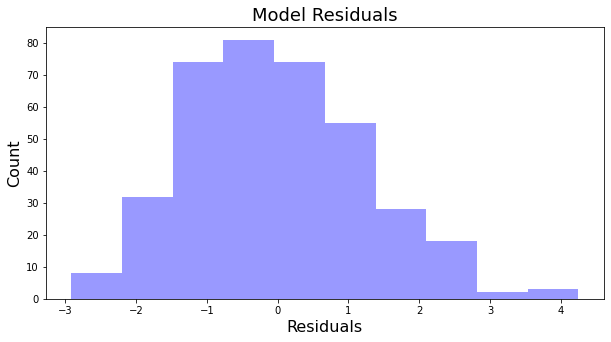

In [27]:
plt.figure(figsize=(10, 5))
sns.distplot(res.resid, kde=False, color='blue', bins=10)
plt.title('Model Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)
#plt.xlim([-2.2, 2.2])

In [28]:
formula = """
req_quality ~ contributor + crowd_pct + similarity  + language +
code_blocks + code_blocks_2 + issue_length + issue_length_2 + issue_length_3 +
total_issues  
"""
y, X = dmatrices(formula, data=down_sample, return_type='dataframe')
mod = sm.GLM(y, X, family=sm.families.Poisson())
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

0.31952466522919276
14
                 Generalized Linear Model Regression Results                  
Dep. Variable:            req_quality   No. Observations:                  375
Model:                            GLM   Df Residuals:                      368
Model Family:                 Poisson   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -639.61
Date:                Sat, 08 Aug 2020   Deviance:                       221.54
Time:                        22:28:52   Pearson chi2:                     215.
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Inter

/home/matt/Envs/phd/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1519: FutureWarning: Anscombe residuals currently unscaled. In a future release, they will be scaled.
  warnings.warn('Anscombe residuals currently unscaled. In a future '


Text(0, 0.5, 'Count')

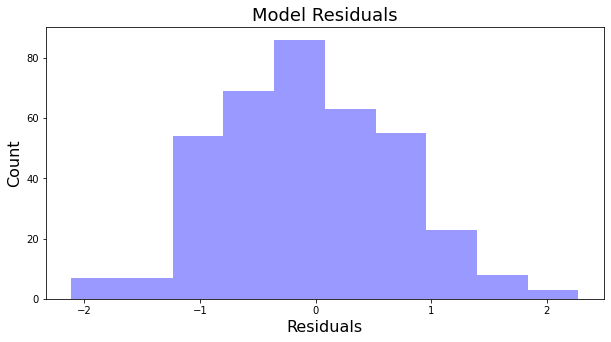

In [29]:
plt.figure(figsize=(10, 5))
sns.distplot(res.resid_anscombe, kde=False, color='blue', bins=10)
plt.title('Model Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)